In [1]:
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
exp_pat = "ensemble"
Image_shape = 224
BATCH_SIZE = 64


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Felix\weather_data_set_ready_to_train\train",
shuffle=True,
batch_size=BATCH_SIZE,
image_size=(300,300))
val_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Felix\weather_data_set_ready_to_train\val",
shuffle=False,
batch_size=BATCH_SIZE,
image_size=(300,300))


y_train = np.concatenate(list(train_ds.map(lambda x,y: y)))
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train),  y=y_train)
class_weights = {i:o for i,o in enumerate(class_weights)}

Found 16567 files belonging to 5 classes.
Found 1571 files belonging to 5 classes.


In [3]:
def get_model(weights=None):

    inputs = tf.keras.Input((300,300 ,3))

    img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.2),
        tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomContrast(factor=0.2),
        tf.keras.layers.RandomCrop(Image_shape,Image_shape)

    ],
    name="img_augmentation",
    )

    x = img_augmentation(inputs)


    base = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    pooling="avg"
    )

    base.trainable = False
    x = base(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(.3, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(5, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)
    model = tf.keras.Model(inputs, outputs)
    if weights:
        model.compile(tf.optimizers.Adam(1e-4 * 5),loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])
        model.load_weights(weights)
    return model

def unfreeze_model(model,n_layers = 20):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization) and not isinstance(layer, tf.keras.layers.LayerNormalization):
            layer.trainable = True
    return model


In [4]:

model = get_model()

model.compile(tf.optimizers.Adam(1e-3),loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

hist1 = model.fit(train_ds,epochs = 2,validation_data=val_ds,initial_epoch=0,class_weight=class_weights)
model = unfreeze_model(model)
model.compile(tf.optimizers.Adam(1e-4 * 5),loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    restore_best_weights=True)

try:
    hist2 = model.fit(train_ds,epochs = 20,validation_data=val_ds,initial_epoch=2, callbacks= [early_stop],class_weight=class_weights)
except KeyboardInterrupt:
    pass


Epoch 1/2
259/259 [==============================] - 30s 87ms/step - loss: 0.6100 - accuracy: 0.8253 - val_loss: 0.6882 - val_accuracy: 0.8440
Epoch 2/2
259/259 [==============================] - 21s 79ms/step - loss: 0.3533 - accuracy: 0.9099 - val_loss: 0.7800 - val_accuracy: 0.8415
Epoch 3/20
259/259 [==============================] - 50s 163ms/step - loss: 0.2382 - accuracy: 0.9419 - val_loss: 1.6421 - val_accuracy: 0.7670
Epoch 4/20
259/259 [==============================] - 41s 157ms/step - loss: 0.1416 - accuracy: 0.9698 - val_loss: 1.5315 - val_accuracy: 0.8542
Epoch 5/20
259/259 [==============================] - 41s 157ms/step - loss: 0.0991 - accuracy: 0.9809 - val_loss: 1.4255 - val_accuracy: 0.8523
Epoch 6/20
259/259 [==============================] - 41s 156ms/step - loss: 0.0893 - accuracy: 0.9801 - val_loss: 1.2857 - val_accuracy: 0.8593
Epoch 7/20
223/259 [========================>.....] - ETA: 5s - loss: 0.0728 - accuracy: 0.9851

In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Felix\weather_data_set_ready_to_train\test",
shuffle=False,
batch_size=BATCH_SIZE,
image_size=(Image_shape,Image_shape))
model.evaluate(test_ds)


Found 1602 files belonging to 5 classes.
26/26 [==============================] - 3s 64ms/step - loss: 2.2614 - accuracy: 0.6717


[2.261406898498535, 0.6716604232788086]

In [5]:
labels = np.concatenate(list(val_ds.map(lambda x,y: y)))
pred = model.predict(val_ds,verbose=1)

confusion_mtx = tf.math.confusion_matrix(labels,np.argmax(pred,axis=-1))


25/25 [==============================] - 3s 78ms/step


In [6]:
p = np.argmax(pred,axis=1)
for i in range(5):

    mask = labels == i
    acc = (labels[mask]==p[mask]).mean()
    print(val_ds.class_names[i],acc)

Clear 0.9942307692307693
Cloudy 0.556
Foggy 0.7567567567567568
Rainy 0.7897435897435897
Snowy 0.9566666666666667


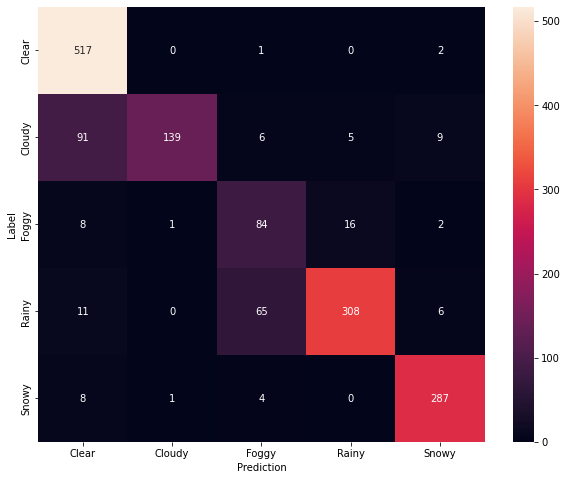

In [7]:

plt.figure(figsize=(10, 8))

names =val_ds.class_names


sns.heatmap(confusion_mtx, xticklabels=names, yticklabels=names, 
          annot=True, fmt='g')
#plt.title(f"Val Confusion Matrix - ACC {acc*100:.2f}%",fontsize=18)
plt.xlabel('Prediction')
plt.ylabel('Label')

plt.show()

In [13]:
{a:i for i,a in enumerate(test_ds.class_names)}

{'Clear': 0, 'Cloudy': 1, 'Foggy': 2, 'Rainy': 3, 'Snowy': 4}

In [14]:
import pandas as pd
df = pd.read_feather("../../weather_data_set_ready_to_train/df.feather").query("ds_type == 'test'")
df["labels"] = df.weather.map({a:i for i,a in enumerate(test_ds.class_names)})
df.path = "../../weather_data_set_ready_to_train/test/"+df.weather + "/" + df.id
df.path.apply(os.path.exists).mean()

1.0

In [15]:
def mapping(path,label):

    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image,[Image_shape,Image_shape])
    return image, label
ds = tf.data.Dataset.from_tensor_slices((df.path.values,df.labels.values)).map(mapping).batch(32)


In [16]:
preds = np.argmax(model.predict(ds),axis=-1)

In [17]:
(preds == df.labels).mean()

0.6716604244694132

In [18]:
false = df[preds!=df.labels]
f_pred = preds[preds!=df.labels]
import tqdm
out = "false/"
os.makedirs(out,exist_ok=True)
for i in tqdm.tqdm(range(len(false))):
    row = false.iloc[i]
    plt.figure(figsize=(10,10))
    plt.imshow(plt.imread(row.path))
    plt.axis("off")
    plt.title(f"{test_ds.class_names[f_pred[i]]} - Label: {row.weather} - {row.origin}")
    plt.savefig(out+str(i)+ ".jpg")
    plt.close()

100%|██████████| 526/526 [00:29<00:00, 17.68it/s]
